In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import shapiro
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import calendar
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plots
from scipy.optimize import linear_sum_assignment # Import for Hungarian algorithm


# Define the path to your data file
file_path = '/content/drive/MyDrive/SSEN LV Aggregated Substations/Master_LV_Aggregated_Substation_data_processed_v3 - outliers set to NaN.csv'

# Load the data into a pandas DataFrame
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully!")
except FileNotFoundError:
    print(f"Error: The file was not found at {file_path}")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

df['data_collection_log_timestamp'] = pd.to_datetime(df['data_collection_log_timestamp'])

# Display the first few rows of the DataFrame
if 'df' in locals():
    print("\nFirst 5 rows of the DataFrame:")
    display(df.head())

    # Display information about the DataFrame
    print("\nDataFrame Info:")
    df.info()

Data loaded successfully!

First 5 rows of the DataFrame:


,dataset_id,dno_alias,aggregated_device_count_active,total_consumption_active_import,data_collection_log_timestamp,geometry,secondary_substation_unique_id,lv_feeder_unique_id,substation_name
0,400600301501,SSEN,31.0,1357.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301501,hazel grove
1,400600301502,SSEN,60.0,6927.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301502,hazel grove
2,400600301503,SSEN,19.0,2368.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301503,hazel grove
3,400600301504,SSEN,67.0,4128.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301504,hazel grove
4,400600301505,SSEN,15.0,1023.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301505,hazel grove



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5303850 entries, 0 to 5303849
Data columns (total 9 columns):
 #   Column                           Dtype              
---  ------                           -----              
 0   dataset_id                       int64              
 1   dno_alias                        object             
 2   aggregated_device_count_active   float64            
 3   total_consumption_active_import  float64            
 4   data_collection_log_timestamp    datetime64[ns, UTC]
 5   geometry                         object             
 6   secondary_substation_unique_id   object             
 7   lv_feeder_unique_id              object             
 8   substation_name                  object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(5)
memory usage: 364.2+ MB


# Task
Import anomaly injection functions from "/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/01_simulation_functions.py", randomly select and save 20 unique feeder IDs from the DataFrame `df` to a file in the same directory, apply the `inject_unmetered_load` function to these feeders within a 3-day time range using intensity levels [0.05, 0.10, 0.20], visualize the original and modified 'total_consumption_active_import' time series for one or two sample feeders, and print a few rows of the modified DataFrame to verify the addition of anomaly metadata columns.

## Import functions

### Subtask:
Import the necessary anomaly injection functions from the specified Python file.


**Reasoning**:
Import the specified function from the Python file.



In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/')

from _01_simulation_functions import (
    inject_unmetered_load,
    inject_offpeak_exploitation,
    inject_gradual_drift,
    inject_smoothed_profile,
    inject_flatline_consumption
)

## Select and save feeder ids

### Subtask:
Randomly select 20 unique feeder IDs from the DataFrame and save them to a file in Google Drive.


**Reasoning**:
Extract unique feeder IDs, randomly sample 20 of them, define the save path, and save the selected IDs to a file in Google Drive.



In [4]:
# import os

# # 1. Extract the unique values from the 'lv_feeder_unique_id' column
# unique_feeder_ids = df['lv_feeder_unique_id'].unique()

# # 2. Randomly sample 20 of these unique feeder IDs
# # Ensure there are at least 20 unique IDs to sample
# if len(unique_feeder_ids) >= 20:
#     selected_feeder_ids = np.random.choice(unique_feeder_ids, 20, replace=False)
# else:
#     # Handle case where there are fewer than 20 unique IDs
#     selected_feeder_ids = unique_feeder_ids
#     print(f"Warning: Only {len(unique_feeder_ids)} unique feeder IDs found. Selecting all of them.")

# # 3. Define the file path where the selected feeder IDs will be saved
# save_directory = '/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/'
# file_name = 'selected_feeder_ids.txt'
# save_path = os.path.join(save_directory, file_name)

# # Ensure the directory exists
# os.makedirs(save_directory, exist_ok=True)

# # 4. Save the selected feeder IDs to the specified file
# with open(save_path, 'w') as f:
#     for feeder_id in selected_feeder_ids:
#         f.write(f"{feeder_id}\n")

# print(f"\nSelected {len(selected_feeder_ids)} feeder IDs saved to: {save_path}")

# # Optional: Display the selected feeder IDs to verify
# print("\nSelected Feeder IDs:")
# for feeder_id in selected_feeder_ids:
#     print(feeder_id)

## Load feeder ids

### Subtask:
Load the saved feeder IDs from the file.


**Reasoning**:
Load the feeder IDs from the saved file into a list for further processing.



In [5]:
import os

# 1. Define the file path where the selected feeder IDs were saved.
save_directory = '/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/'
file_name = 'selected_feeder_ids.txt'
load_path = os.path.join(save_directory, file_name)

# 2. Initialize an empty list to store the loaded feeder IDs.
loaded_feeder_ids = []

# 3. Open the saved file in read mode.
try:
    with open(load_path, 'r') as f:
        # 4. Read each line from the file, strip whitespace, and append to the list.
        for line in f:
            loaded_feeder_ids.append(line.strip())

    # 6. Print the number of loaded feeder IDs and the first few IDs to verify.
    print(f"\nSuccessfully loaded {len(loaded_feeder_ids)} feeder IDs from: {load_path}")
    if loaded_feeder_ids:
        print("First 5 loaded Feeder IDs:")
        for i, feeder_id in enumerate(loaded_feeder_ids[:5]):
            print(feeder_id)
except FileNotFoundError:
    print(f"Error: The file was not found at {load_path}")
except Exception as e:
    print(f"An error occurred while loading the feeder IDs: {e}")



Successfully loaded 20 feeder IDs from: /content/drive/MyDrive/Anomaly Detection Work/1. Clustering/selected_feeder_ids.txt
First 5 loaded Feeder IDs:
SSEN-491100602001
SSEN-490402400501
SSEN-461800710004
SSEN-462600150003
SSEN-461800108003


## Define time range

### Subtask:
Define a specific time range for injecting anomalies (e.g., 3 consecutive days).


**Reasoning**:
Define the start and end dates for the 3-day anomaly injection period and print the chosen time range.



In [6]:
from datetime import datetime, timedelta
import pytz

# Define the start date and time for the anomaly injection (e.g., start of a specific day)
# Use a timezone-aware datetime object to match the DataFrame's timestamp format
anomaly_start_time = datetime(2024, 3, 1, 0, 0, 0, tzinfo=pytz.UTC)

# Define the end date and time (3 days after the start time)
anomaly_end_time = anomaly_start_time + timedelta(days=3)

# Print the defined time range
print(f"Anomaly injection start time: {anomaly_start_time}")
print(f"Anomaly injection end time: {anomaly_end_time}")

Anomaly injection start time: 2024-03-01 00:00:00+00:00
Anomaly injection end time: 2024-03-04 00:00:00+00:00


## Inject anomalies

### Subtask:
Apply the `inject_unmetered_load` function to the selected feeders within the defined time range with specified intensity levels.


**Reasoning**:
Check if the inject_unmetered_load function is available and then apply it to the selected feeders within the defined time range and intensity levels.



In [7]:
# Check if the inject_unmetered_load function is available
if 'inject_unmetered_load' not in globals():
    print("Error: The 'inject_unmetered_load' function was not imported successfully in a previous step.")
    print("This step cannot be completed.")
else:
    # Define the intensity levels for anomaly injection
    intensity_levels = [0.05, 0.10, 0.20]

    # Define the time range as a tuple
    anomaly_time_range = (anomaly_start_time, anomaly_end_time)

    # Apply the inject_unmetered_load function
    # The function should return a new DataFrame with anomalies injected and metadata added
    df_anomalies = inject_unmetered_load(
        df,
        loaded_feeder_ids,
        intensity_levels,
        time_range=anomaly_time_range # Pass the time range as a tuple to the time_range parameter
    )

    print("Anomaly injection process completed.")

    # Optional: Print a few rows of the modified DataFrame to verify
    print("\nFirst 5 rows of the DataFrame after anomaly injection:")
    display(df_anomalies.head())

    # Optional: Display info to see the new columns
    print("\nDataFrame Info after anomaly injection:")
    df_anomalies.info()

Anomaly injection process completed.

First 5 rows of the DataFrame after anomaly injection:


,dataset_id,dno_alias,aggregated_device_count_active,total_consumption_active_import,data_collection_log_timestamp,geometry,secondary_substation_unique_id,lv_feeder_unique_id,substation_name,anomaly_type,anomaly_intensity,anomaly_id
0,400600301501,SSEN,31.0,1357.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301501,hazel grove,NaN,NaN,NaN
1,400600301502,SSEN,60.0,6927.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301502,hazel grove,NaN,NaN,NaN
2,400600301503,SSEN,19.0,2368.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301503,hazel grove,NaN,NaN,NaN
3,400600301504,SSEN,67.0,4128.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301504,hazel grove,NaN,NaN,NaN
4,400600301505,SSEN,15.0,1023.0,2024-02-12 00:30:00+00:00,"{'x': -1.132322, 'y': 51.600559}",SSEN-4006003015,SSEN-400600301505,hazel grove,NaN,NaN,NaN



DataFrame Info after anomaly injection:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5303850 entries, 0 to 5303849
Data columns (total 12 columns):
 #   Column                           Dtype              
---  ------                           -----              
 0   dataset_id                       int64              
 1   dno_alias                        object             
 2   aggregated_device_count_active   float64            
 3   total_consumption_active_import  float64            
 4   data_collection_log_timestamp    datetime64[ns, UTC]
 5   geometry                         object             
 6   secondary_substation_unique_id   object             
 7   lv_feeder_unique_id              object             
 8   substation_name                  object             
 9   anomaly_type                     object             
 10  anomaly_intensity                float64            
 11  anomaly_id                       object             
dtypes: datetime64[ns, UTC](1), fl

## Visualize results

### Subtask:
Select one or two sample feeders and create line plots to compare the original and modified 'total_consumption_active_import' time series.

**Reasoning**:
Filter the original and modified DataFrames for the selected sample feeders, sort by timestamp, and create a line plot for each feeder showing both the original and anomalous time series for the 'total_consumption_active_import' column within the anomaly injection time range.


Visualizing feeder ID: SSEN-491100602001


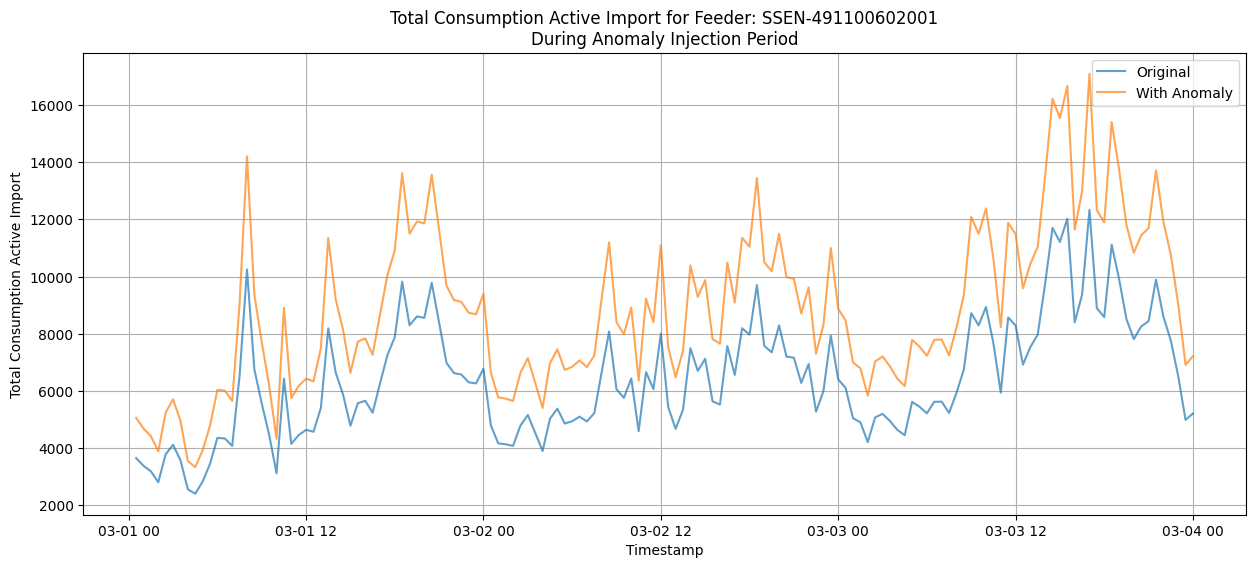


Visualizing feeder ID: SSEN-490402400501


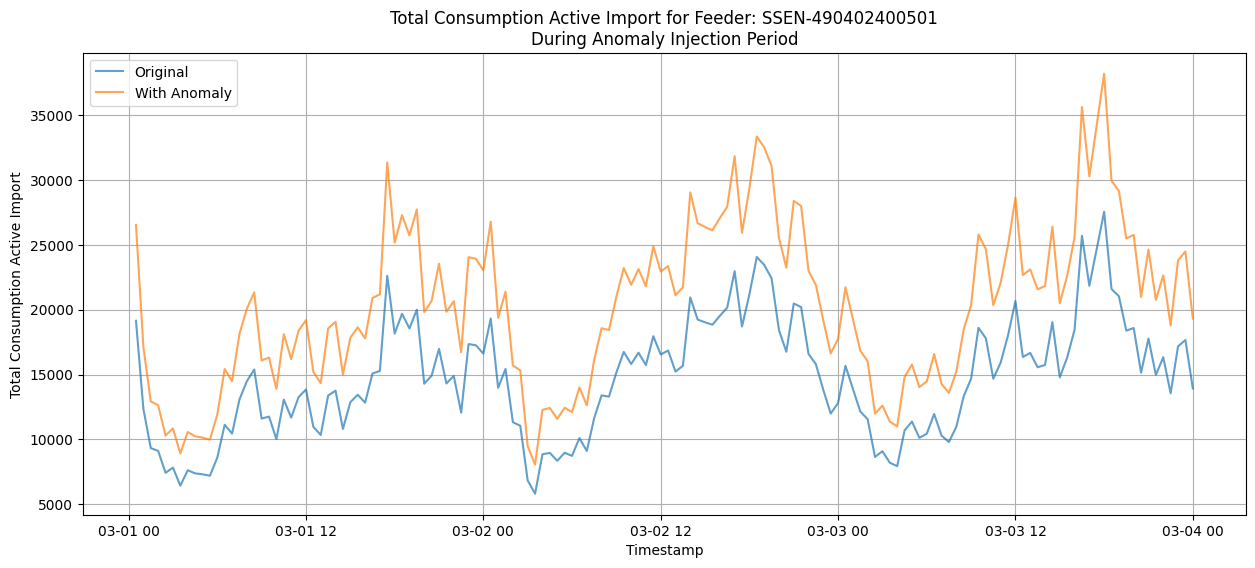

In [8]:
# Select one or two sample feeder IDs from the loaded_feeder_ids list for visualization
# Ensure there are enough feeders in the list to select from
if len(loaded_feeder_ids) >= 2:
    sample_feeder_ids_for_viz = loaded_feeder_ids[:2] # Select the first two for simplicity
elif len(loaded_feeder_ids) == 1:
     sample_feeder_ids_for_viz = loaded_feeder_ids[:1] # Select the first one
else:
    sample_feeder_ids_for_viz = []
    print("Warning: Not enough loaded feeder IDs to select samples for visualization.")


if sample_feeder_ids_for_viz:
    for feeder_id in sample_feeder_ids_for_viz:
        print(f"\nVisualizing feeder ID: {feeder_id}")

        # Filter the original DataFrame for the current feeder and time range
        df_original_feeder = df[
            (df['lv_feeder_unique_id'] == feeder_id) &
            (df['data_collection_log_timestamp'] >= anomaly_start_time) &
            (df['data_collection_log_timestamp'] <= anomaly_end_time)
        ].sort_values('data_collection_log_timestamp')

        # Filter the modified DataFrame for the current feeder and time range
        df_anomalies_feeder = df_anomalies[
            (df_anomalies['lv_feeder_unique_id'] == feeder_id) &
            (df_anomalies['data_collection_log_timestamp'] >= anomaly_start_time) &
            (df_anomalies['data_collection_log_timestamp'] <= anomaly_end_time)
        ].sort_values('data_collection_log_timestamp')

        # Check if there is data to plot for this feeder
        if not df_original_feeder.empty and not df_anomalies_feeder.empty:
            # Create the plot
            plt.figure(figsize=(15, 6))
            plt.plot(df_original_feeder['data_collection_log_timestamp'], df_original_feeder['total_consumption_active_import'], label='Original', alpha=0.7)
            plt.plot(df_anomalies_feeder['data_collection_log_timestamp'], df_anomalies_feeder['total_consumption_active_import'], label='With Anomaly', alpha=0.7)

            plt.title(f'Total Consumption Active Import for Feeder: {feeder_id}\nDuring Anomaly Injection Period')
            plt.xlabel('Timestamp')
            plt.ylabel('Total Consumption Active Import')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"No data available to plot for feeder ID: {feeder_id} within the specified time range.")

## Verify anomaly metadata

### Subtask:
Print a few rows of the modified DataFrame to confirm the addition of anomaly metadata columns.

**Reasoning**:
Display the first few rows of the DataFrame with injected anomalies to visually inspect the new 'anomaly_type', 'anomaly_intensity', and 'anomaly_id' columns and confirm that they contain expected values for rows within the anomaly injection time range for the selected feeders.

In [9]:
# Filter the modified DataFrame to show only rows within the anomaly injection time range
# for the selected sample feeders, where anomalies should have been injected.
if sample_feeder_ids_for_viz:
    df_anomalies_subset = df_anomalies[
        (df_anomalies['lv_feeder_unique_id'].isin(sample_feeder_ids_for_viz)) &
        (df_anomalies['data_collection_log_timestamp'] >= anomaly_start_time) &
        (df_anomalies['data_collection_log_timestamp'] <= anomaly_end_time)
    ]

    print("\nRows from the modified DataFrame within the anomaly injection time range for sample feeders:")
    if not df_anomalies_subset.empty:
        display(df_anomalies_subset.head())
        display(df_anomalies_subset.tail()) # Display tail as well to see more data points
    else:
        print("No anomalous data found for the sample feeders within the specified time range.")


Rows from the modified DataFrame within the anomaly injection time range for sample feeders:


,dataset_id,dno_alias,aggregated_device_count_active,total_consumption_active_import,data_collection_log_timestamp,geometry,secondary_substation_unique_id,lv_feeder_unique_id,substation_name,anomaly_type,anomaly_intensity,anomaly_id
187022,490402400501,SSEN,68.0,26522.496,2024-03-01 00:30:00+00:00,"{'x': -1.268976, 'y': 51.611765}",SSEN-4904024005,SSEN-490402400501,Dan Read Parade,unmetered_load,0.2,SSEN-490402400501_unmetered_load_0.20
187031,491100602001,SSEN,26.0,5061.672,2024-03-01 00:30:00+00:00,"{'x': -1.240284, 'y': 51.709936}",SSEN-4911006020,SSEN-491100602001,poplar grove garages,unmetered_load,0.2,SSEN-491100602001_unmetered_load_0.20
187251,490402400501,SSEN,68.0,17124.030,2024-03-01 01:00:00+00:00,"{'x': -1.268976, 'y': 51.611765}",SSEN-4904024005,SSEN-490402400501,Dan Read Parade,unmetered_load,0.2,SSEN-490402400501_unmetered_load_0.20
187260,491100602001,SSEN,26.0,4687.452,2024-03-01 01:00:00+00:00,"{'x': -1.240284, 'y': 51.709936}",SSEN-4911006020,SSEN-491100602001,poplar grove garages,unmetered_load,0.2,SSEN-491100602001_unmetered_load_0.20
187480,490402400501,SSEN,68.0,12932.766,2024-03-01 01:30:00+00:00,"{'x': -1.268976, 'y': 51.611765}",SSEN-4904024005,SSEN-490402400501,Dan Read Parade,unmetered_load,0.2,SSEN-490402400501_unmetered_load_0.20


,dataset_id,dno_alias,aggregated_device_count_active,total_consumption_active_import,data_collection_log_timestamp,geometry,secondary_substation_unique_id,lv_feeder_unique_id,substation_name,anomaly_type,anomaly_intensity,anomaly_id
219320,491100602001,SSEN,26.0,9050.580,2024-03-03 23:00:00+00:00,"{'x': -1.240284, 'y': 51.709936}",SSEN-4911006020,SSEN-491100602001,poplar grove garages,unmetered_load,0.2,SSEN-491100602001_unmetered_load_0.20
219540,490402400501,SSEN,68.0,24473.988,2024-03-03 23:30:00+00:00,"{'x': -1.268976, 'y': 51.611765}",SSEN-4904024005,SSEN-490402400501,Dan Read Parade,unmetered_load,0.2,SSEN-490402400501_unmetered_load_0.20
219549,491100602001,SSEN,25.0,6914.754,2024-03-03 23:30:00+00:00,"{'x': -1.240284, 'y': 51.709936}",SSEN-4911006020,SSEN-491100602001,poplar grove garages,unmetered_load,0.2,SSEN-491100602001_unmetered_load_0.20
219769,490402400501,SSEN,68.0,19305.594,2024-03-04 00:00:00+00:00,"{'x': -1.268976, 'y': 51.611765}",SSEN-4904024005,SSEN-490402400501,Dan Read Parade,unmetered_load,0.2,SSEN-490402400501_unmetered_load_0.20
219778,491100602001,SSEN,25.0,7221.060,2024-03-04 00:00:00+00:00,"{'x': -1.240284, 'y': 51.709936}",SSEN-4911006020,SSEN-491100602001,poplar grove garages,unmetered_load,0.2,SSEN-491100602001_unmetered_load_0.20


# Task
Run anomaly simulations on a smart meter time series dataset (`df`) using functions from `/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/01_simulation_functions.py`. For a fixed set of 20 feeder IDs, inject 5 different anomaly types at multiple intensity levels. After each injection, recalculate a feeder-level feature matrix following a specific 4-step process (daily features, merge/clean, aggregate, select/normalize) and save the resulting 244x13 feature matrix (including feeder ID) as a CSV file named `features_<anomaly_type>_<intensity>.csv` in the directory `/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/01. Simulated Feature Matrices/`.

## Define simulation parameters

### Subtask:
Set up the dictionary containing anomaly types, intensity levels, and the list of selected feeder IDs.


**Reasoning**:
I will create the `simulation_params` dictionary with the specified anomaly types and their corresponding intensity levels, as requested in the instructions. This dictionary is essential for iterating through the different anomaly simulations in the subsequent steps.



In [10]:
simulation_params = {
    'unmetered_load': [0.05, 0.10, 0.20],
    'offpeak_exploitation': [0.05, 0.10, 0.20],
    'gradual_drift': [0.05, 0.10, 0.20],
    'smoothed_profile': [0.05, 0.10, 0.20],
    'flatline_consumption': [5, 10, 20]
}

# The 'loaded_feeder_ids' list is already available in the environment from a previous step.
# We can print it to confirm.
print("Simulation Parameters:")
print(simulation_params)
print("\nLoaded Feeder IDs:")
print(loaded_feeder_ids)

Simulation Parameters:
{'unmetered_load': [0.05, 0.1, 0.2], 'offpeak_exploitation': [0.05, 0.1, 0.2], 'gradual_drift': [0.05, 0.1, 0.2], 'smoothed_profile': [0.05, 0.1, 0.2], 'flatline_consumption': [5, 10, 20]}

Loaded Feeder IDs:
['SSEN-491100602001', 'SSEN-490402400501', 'SSEN-461800710004', 'SSEN-462600150003', 'SSEN-461800108003', 'SSEN-460600208001', 'SSEN-461800530002', 'SSEN-490400102006', 'SSEN-461800210002', 'SSEN-400600301502', 'SSEN-461800310002', 'SSEN-461800614004', 'SSEN-460600105005', 'SSEN-460501021002', 'SSEN-462600310001', 'SSEN-462600148004', 'SSEN-461800210004', 'SSEN-460501021001', 'SSEN-491100604004', 'SSEN-461800702006']


## Initialize output directory

### Subtask:
Create the directory in Google Drive where the resulting feature matrices will be saved.


**Reasoning**:
Define the output directory path and create it using the os module.



In [11]:
import os

# 1. Define the full path for the output directory
output_directory_name = '01. Simulated Feature Matrices'
output_directory_path = os.path.join(save_directory, output_directory_name)

# 2. Use the os module to create the output directory.
os.makedirs(output_directory_path, exist_ok=True)

# 3. Print a message confirming the directory has been created or already exists.
print(f"Output directory created or already exists: {output_directory_path}")

Output directory created or already exists: /content/drive/MyDrive/Anomaly Detection Work/1. Clustering/01. Simulated Feature Matrices


## Iterate through anomalies and intensities

### Subtask:
Loop through each anomaly type and its corresponding intensity levels defined in the parameters.


**Reasoning**:
Iterate through the simulation parameters to print the anomaly type and intensity level for each combination.



In [13]:
# Iterate through each anomaly type and its intensity levels
for anomaly_type, intensity_levels in simulation_params.items():
    # Iterate through each intensity level for the current anomaly type
    for intensity in intensity_levels:
        # Print the current anomaly type and intensity level being processed
        print(f"Processing Anomaly Type: {anomaly_type}, Intensity Level: {intensity}")

        # 1. Check if the function corresponding to the current anomaly_type exists.
        function_name = f"inject_{anomaly_type}"
        if function_name not in globals():
            print(f"Error: The function '{function_name}' was not imported successfully.")
            print("Skipping this anomaly injection.")
        else:
            # Get the function object from its name
            inject_anomaly_function = globals()[function_name]

            # 2. Call the appropriate anomaly injection function
            # Pass the current intensity as a list with a single element
            df_anomalies_injected = inject_anomaly_function(
                df.copy(), # Work on a copy to avoid modifying the original df in place in the loop
                loaded_feeder_ids,
                [intensity], # Pass intensity as a list
                time_range=anomaly_time_range
            )

            # 3. The returned DataFrame is stored in df_anomalies_injected
            # 4. Print a confirmation message
            print(f"Anomaly injection complete for {anomaly_type} with intensity {intensity}.")

            df_anomalies_injected['consumption_per_device'] = df_anomalies_injected['total_consumption_active_import'] / df_anomalies_injected['aggregated_device_count_active']
            df_anomalies_injected['consumption_per_device'] = df_anomalies_injected['consumption_per_device'].replace([np.inf, -np.inf], np.nan)

            df_anomalies_injected['date'] = df_anomalies_injected['data_collection_log_timestamp'].dt.date

            sampling_interval_minutes = 30
            sampling_interval_hours = sampling_interval_minutes / 60.0

            # 95th percentile threshold for each feeder-day
            daily_peak_thresholds = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].quantile(0.95).reset_index(name='peak_threshold_95th')
            df_with_threshold = pd.merge(df_anomalies_injected, daily_peak_thresholds, on=['lv_feeder_unique_id', 'date'], how='left')

            df_with_threshold['above_peak_threshold'] = (df_with_threshold['total_consumption_active_import'] > df_with_threshold['peak_threshold_95th']).astype(int)
            daily_peak_duration_intervals = df_with_threshold.groupby(['lv_feeder_unique_id', 'date'])['above_peak_threshold'].sum().reset_index(name='peak_duration_intervals')
            daily_peak_duration_intervals['mean_daily_time_at_peak'] = daily_peak_duration_intervals['peak_duration_intervals'] * sampling_interval_hours

            # Daily aggregation
            daily_feeder_features = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date']).agg(
                avg_daily_consumption_per_device=('consumption_per_device', 'mean'),
                std_daily_consumption_per_device=('consumption_per_device', 'std'),
                avg_total_consumption_daily=('total_consumption_active_import', 'mean'),
                std_total_consumption_daily=('total_consumption_active_import', 'std'),
                avg_max_consumption_daily=('total_consumption_active_import', 'max'),
                std_max_consumption_daily=('total_consumption_active_import', lambda x: np.std(x) if len(x) > 1 else np.nan),
                avg_aggregated_device_count=('aggregated_device_count_active', 'mean'),
                max_total_consumption_daily=('total_consumption_active_import', 'max'),
                min_total_consumption_daily=('total_consumption_active_import', 'min')
            ).reset_index()

            # Merge in peak duration
            daily_feeder_features = pd.merge(
                daily_feeder_features,
                daily_peak_duration_intervals[['lv_feeder_unique_id', 'date', 'mean_daily_time_at_peak']],
                on=['lv_feeder_unique_id', 'date'],
                how='left'
            )

            daily_feeder_features['max_to_mean_ratio'] = daily_feeder_features['avg_max_consumption_daily'] / daily_feeder_features['avg_total_consumption_daily']
            daily_feeder_features['std_to_mean_ratio'] = daily_feeder_features['std_daily_consumption_per_device'] / daily_feeder_features['avg_daily_consumption_per_device']
            daily_feeder_features['per_device_peak_ratio'] = daily_feeder_features['avg_max_consumption_daily'] / daily_feeder_features['avg_aggregated_device_count']

            daily_feeder_features['max_to_min_ratio'] = np.where(
                daily_feeder_features['min_total_consumption_daily'] == 0,
                np.nan,
                daily_feeder_features['max_total_consumption_daily'] / daily_feeder_features['min_total_consumption_daily']
            )

            df_anomalies_injected['day_of_week'] = df_anomalies_injected['data_collection_log_timestamp'].dt.dayofweek
            df_anomalies_injected['weekday_weekend'] = df_anomalies_injected['day_of_week'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')
            weekday_weekend_consumption = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'weekday_weekend']).agg(
                avg_consumption=('total_consumption_active_import', 'mean')
            ).reset_index()

            weekday_weekend_pivot = weekday_weekend_consumption.pivot(
                index='lv_feeder_unique_id',
                columns='weekday_weekend',
                values='avg_consumption'
            ).reset_index()

            weekday_weekend_pivot['weekday_weekend_ratio'] = np.where(
                weekday_weekend_pivot['weekend'].isna() | (weekday_weekend_pivot['weekend'] == 0),
                np.nan,
                weekday_weekend_pivot['weekday'] / weekday_weekend_pivot['weekend']
            )

            # Merge ratio into daily features
            daily_feeder_features = daily_feeder_features.merge(
                weekday_weekend_pivot[['lv_feeder_unique_id', 'weekday_weekend_ratio']],
                on='lv_feeder_unique_id',
                how='left'
            )

            daily_feeder_features.drop(columns=[
                'avg_aggregated_device_count', 'max_total_consumption_daily', 'min_total_consumption_daily'
            ], inplace=True)

            feature_columns = [
                'avg_daily_consumption_per_device', 'std_daily_consumption_per_device',
                'avg_total_consumption_daily', 'std_total_consumption_daily',
                'avg_max_consumption_daily', 'std_max_consumption_daily',
                'max_to_mean_ratio', 'std_to_mean_ratio',
                'per_device_peak_ratio', 'max_to_min_ratio',
                'weekday_weekend_ratio', 'mean_daily_time_at_peak'
            ]

            daily_feeder_features[feature_columns] = daily_feeder_features[feature_columns].replace([np.inf, -np.inf], np.nan)

            for col in feature_columns:
                if daily_feeder_features[col].isnull().any():
                    mean_value = daily_feeder_features[col].mean()
                    daily_feeder_features[col].fillna(mean_value, inplace=True)

            feeder_level_features = daily_feeder_features.groupby('lv_feeder_unique_id')[feature_columns].mean().reset_index()

            # Add anomaly metadata columns
            feeder_level_features['anomaly_type'] = anomaly_type
            feeder_level_features['anomaly_intensity'] = intensity
            feeder_level_features['anomaly_id'] = feeder_level_features['lv_feeder_unique_id'] + '-' + anomaly_type + '-' + str(intensity)
            feeder_level_features['is_anomalous'] = feeder_level_features['lv_feeder_unique_id'].isin(loaded_feeder_ids).astype(int)



            # 2. Create a new DataFrame by selecting these 12 columns
            df_selected_features = feeder_level_features[feature_columns].copy()

            # 3. Instantiate a StandardScaler object
            scaler = StandardScaler()

            # 4. Fit the scaler to the selected features and transform
            df_normalized_features = pd.DataFrame(scaler.fit_transform(df_selected_features), columns=feature_columns)

            # Add the 'lv_feeder_unique_id' back to the normalized DataFrame
            df_normalized_features['lv_feeder_unique_id'] = feeder_level_features['lv_feeder_unique_id']

            # Reorder columns to have feeder ID first
            df_normalized_features = df_normalized_features[['lv_feeder_unique_id'] + feature_columns]

            # Create columns with 'object' dtype before assigning string values
            # df_normalized_features['anomaly_type'] = feeder_level_features['anomaly_type'].astype(object)
            # df_normalized_features['anomaly_intensity'] = feeder_level_features['anomaly_intensity'].astype(object)
            # df_normalized_features['anomaly_id'] = feeder_level_features['anomaly_id'].astype(object)
            # df_normalized_features['is_anomalous'] = feeder_level_features['is_anomalous'].astype(int)
            # # Add anomaly metadata columns only to anomalous feeders
            df_normalized_features['is_anomalous'] = feeder_level_features['is_anomalous'].astype(int)

            # # Use np.where to assign metadata only where is_anomalous == 1
            df_normalized_features['anomaly_type'] = np.where(
                df_normalized_features['is_anomalous'] == 1,
                anomaly_type,
                None
            ).astype('object')

            df_normalized_features['anomaly_intensity'] = np.where(
                df_normalized_features['is_anomalous'] == 1,
                intensity,
                None
            ).astype('object')

            df_normalized_features['anomaly_id'] = np.where(
                df_normalized_features['is_anomalous'] == 1,
                df_normalized_features['lv_feeder_unique_id'] + '-' + anomaly_type + '-' + str(intensity),
                None
            ).astype('object')



            # 5. Display the first few rows of the normalized DataFrame
            print("\nFirst 5 rows of the normalized feeder-level features:")
            display(df_normalized_features.head())

            print("\nNormalized feeder-level features Info:")
            df_normalized_features.info()


            # 1. Construct the filename
            filename = f"features_{anomaly_type}_{intensity}.csv"

            # 2. Construct the full save path
            # The output_directory_path is defined in a previous step: '/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/01. Simulated Feature Matrices'
            save_path = os.path.join(output_directory_path, filename)

            # 3. Save the df_normalized_features DataFrame to a CSV file
            df_normalized_features.to_csv(save_path, index=False)

            # 4. Print a confirmation message
            print(f"\nSuccessfully saved {filename} to {save_path}")

            # filename = f"features_{anomaly_type}_{intensity}.csv"
            # feeder_level_features.to_csv(f"/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/01. Simulated Feature Matrices/{filename}", index=False)




Processing Anomaly Type: unmetered_load, Intensity Level: 0.05
Anomaly injection complete for unmetered_load with intensity 0.05.

First 5 rows of the normalized feeder-level features:


/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827393,-0.379293,-0.579269,-0.421191,-0.510542,-0.420618,0.661996,0.886974,-0.578107,0.620394,-0.284727,0.161642,0,None,None,None
1,SSEN-400600301502,-0.582819,-0.493354,1.249974,1.637216,1.455532,1.637116,-0.415939,-0.255822,-0.592861,-0.446118,-0.109749,0.184021,1,unmetered_load,0.05,SSEN-400600301502-unmetered_load-0.05
2,SSEN-400600301503,-0.718420,-0.301245,-0.705940,-0.633245,-0.653258,-0.633196,1.039042,0.975841,-0.415947,0.758406,-0.191869,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855902,-0.767801,0.978365,1.042467,1.004505,1.042870,-0.724715,-0.669561,-0.875480,-0.588679,0.236014,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848915,-0.337800,-0.761203,-0.657369,-0.702833,-0.656878,1.269678,1.272838,-0.498486,1.188158,-0.659324,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827454,-0.379337,-0.579298,-0.421228,-0.510575,-0.420655,0.661997,0.886975,-0.578157,0.620394,-0.283751,0.161642,0,None,None,None
1,SSEN-400600301502,-0.582300,-0.492955,1.250759,1.638322,1.456431,1.638222,-0.415946,-0.255839,-0.592434,-0.446118,-0.119786,0.184021,1,unmetered_load,0.1,SSEN-400600301502-unmetered_load-0.1
2,SSEN-400600301503,-0.718482,-0.301290,-0.705968,-0.633279,-0.653289,-0.633230,1.039044,0.975841,-0.415999,0.758406,-0.190902,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855963,-0.767843,0.978321,1.042411,1.004456,1.042815,-0.724715,-0.669560,-0.875528,-0.588679,0.236937,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848977,-0.337845,-0.761230,-0.657402,-0.702863,-0.656912,1.269679,1.272839,-0.498538,1.188158,-0.658309,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827578,-0.379427,-0.579355,-0.421302,-0.510640,-0.420729,0.662000,0.886974,-0.578258,0.620394,-0.281795,0.161642,0,None,None,None
1,SSEN-400600301502,-0.581261,-0.492156,1.252329,1.640536,1.458228,1.640436,-0.415960,-0.255874,-0.591580,-0.446118,-0.139803,0.184021,1,unmetered_load,0.2,SSEN-400600301502-unmetered_load-0.2
2,SSEN-400600301503,-0.718607,-0.301380,-0.706022,-0.633347,-0.653351,-0.633299,1.039046,0.975840,-0.416103,0.758406,-0.188969,0.146723,0,None,None,None
3,SSEN-400600301504,-0.856086,-0.767926,0.978234,1.042300,1.004357,1.042704,-0.724713,-0.669559,-0.875624,-0.588679,0.238768,0.176561,0,None,None,None
4,SSEN-400600301505,-0.849100,-0.337935,-0.761284,-0.657471,-0.702924,-0.656980,1.269682,1.272838,-0.498640,1.188158,-0.656263,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827336,-0.379243,-0.579243,-0.421150,-0.510511,-0.420577,0.662001,0.886986,-0.578057,0.620409,-0.285619,0.161642,0,None,None,None
1,SSEN-400600301502,-0.583302,-0.493823,1.249244,1.635924,1.454632,1.635824,-0.416056,-0.256142,-0.593289,-0.446129,-0.100332,0.184021,1,offpeak_exploitation,0.05,SSEN-400600301502-offpeak_exploitation-0.05
2,SSEN-400600301503,-0.718362,-0.301195,-0.705915,-0.633207,-0.653228,-0.633158,1.039045,0.975851,-0.415897,0.758420,-0.192753,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855845,-0.767753,0.978405,1.042531,1.004554,1.042935,-0.724704,-0.669534,-0.875431,-0.588665,0.235165,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848859,-0.337751,-0.761179,-0.657331,-0.702804,-0.656840,1.269680,1.272846,-0.498436,1.188173,-0.660247,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827341,-0.379240,-0.579245,-0.421146,-0.510513,-0.420573,0.662000,0.886995,-0.578059,0.620414,-0.285536,0.161642,0,None,None,None
1,SSEN-400600301502,-0.583267,-0.493888,1.249298,1.635748,1.454630,1.635648,-0.416179,-0.256466,-0.593290,-0.446120,-0.100968,0.184021,1,offpeak_exploitation,0.1,SSEN-400600301502-offpeak_exploitation-0.1
2,SSEN-400600301503,-0.718367,-0.301192,-0.705917,-0.633204,-0.653231,-0.633155,1.039040,0.975859,-0.415899,0.758426,-0.192671,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855850,-0.767747,0.978401,1.042539,1.004552,1.042943,-0.724690,-0.669507,-0.875431,-0.588657,0.235244,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848864,-0.337747,-0.761181,-0.657328,-0.702806,-0.656838,1.269672,1.272851,-0.498438,1.188177,-0.660162,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827351,-0.379234,-0.579250,-0.421142,-0.510518,-0.420568,0.661997,0.887008,-0.578062,0.620419,-0.285371,0.161642,0,None,None,None
1,SSEN-400600301502,-0.583195,-0.494009,1.249407,1.635428,1.454626,1.635328,-0.416423,-0.257064,-0.593293,-0.446111,-0.102242,0.184021,1,offpeak_exploitation,0.2,SSEN-400600301502-offpeak_exploitation-0.2
2,SSEN-400600301503,-0.718377,-0.301187,-0.705922,-0.633200,-0.653236,-0.633151,1.039029,0.975870,-0.415905,0.758430,-0.192508,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855860,-0.767737,0.978394,1.042551,1.004547,1.042955,-0.724662,-0.669459,-0.875430,-0.588646,0.235402,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848873,-0.337742,-0.761185,-0.657325,-0.702812,-0.656834,1.269656,1.272855,-0.498443,1.188179,-0.659992,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827363,-0.379276,-0.579256,-0.421178,-0.510527,-0.420604,0.661994,0.886966,-0.578084,0.620387,-0.284921,0.161642,0,None,None,None
1,SSEN-400600301502,-0.583056,-0.493485,1.249615,1.636849,1.455163,1.636750,-0.415812,-0.255629,-0.593035,-0.446003,-0.107826,0.184021,1,gradual_drift,0.05,SSEN-400600301502-gradual_drift-0.05
2,SSEN-400600301503,-0.718390,-0.301228,-0.705927,-0.633232,-0.653244,-0.633183,1.039040,0.975832,-0.415924,0.758399,-0.192062,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855872,-0.767786,0.978385,1.042485,1.004526,1.042889,-0.724721,-0.669574,-0.875458,-0.588687,0.235829,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848886,-0.337784,-0.761191,-0.657356,-0.702819,-0.656865,1.269677,1.272831,-0.498463,1.188151,-0.659525,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827396,-0.379304,-0.579271,-0.421201,-0.510545,-0.420628,0.661992,0.886958,-0.578112,0.620380,-0.284140,0.161642,0,None,None,None
1,SSEN-400600301502,-0.582774,-0.493216,1.250040,1.637591,1.455693,1.637491,-0.415699,-0.255462,-0.592781,-0.445892,-0.115947,0.184021,1,gradual_drift,0.1,SSEN-400600301502-gradual_drift-0.1
2,SSEN-400600301503,-0.718423,-0.301256,-0.705942,-0.633254,-0.653261,-0.633205,1.039040,0.975824,-0.415952,0.758392,-0.191288,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855905,-0.767813,0.978362,1.042448,1.004498,1.042852,-0.724725,-0.669586,-0.875485,-0.588694,0.236569,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848919,-0.337812,-0.761205,-0.657378,-0.702835,-0.656887,1.269677,1.272824,-0.498491,1.188144,-0.658714,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827461,-0.379361,-0.579301,-0.421249,-0.510581,-0.420676,0.661989,0.886941,-0.578168,0.620367,-0.282574,0.161642,0,None,None,None
1,SSEN-400600301502,-0.582210,-0.492676,1.250891,1.639078,1.456752,1.638978,-0.415489,-0.255148,-0.592275,-0.445681,-0.132157,0.184021,1,gradual_drift,0.2,SSEN-400600301502-gradual_drift-0.2
2,SSEN-400600301503,-0.718489,-0.301314,-0.705971,-0.633298,-0.653295,-0.633249,1.039039,0.975808,-0.416009,0.758379,-0.189739,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855970,-0.767867,0.978316,1.042373,1.004441,1.042777,-0.724734,-0.669609,-0.875538,-0.588708,0.238041,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848983,-0.337869,-0.761233,-0.657421,-0.702869,-0.656930,1.269676,1.272809,-0.498548,1.188131,-0.657081,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827331,-0.379210,-0.579241,-0.421119,-0.510503,-0.420546,0.662018,0.887063,-0.578046,0.620492,-0.285706,0.161642,0,None,None,None
1,SSEN-400600301502,-0.583338,-0.494230,1.249189,1.634833,1.454157,1.634733,-0.416897,-0.257472,-0.593528,-0.447459,-0.099700,0.184021,1,smoothed_profile,0.05,SSEN-400600301502-smoothed_profile-0.05
2,SSEN-400600301503,-0.718357,-0.301161,-0.705913,-0.633180,-0.653222,-0.633131,1.039062,0.975928,-0.415885,0.758506,-0.192840,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855840,-0.767721,0.978408,1.042592,1.004574,1.042996,-0.724684,-0.669463,-0.875421,-0.588602,0.235081,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848854,-0.337717,-0.761177,-0.657305,-0.702798,-0.656814,1.269696,1.272924,-0.498425,1.188265,-0.660337,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827331,-0.379178,-0.579241,-0.421090,-0.510498,-0.420516,0.662035,0.887133,-0.578037,0.620496,-0.285711,0.161642,0,None,None,None
1,SSEN-400600301502,-0.583338,-0.494672,1.249189,1.633655,1.453680,1.633555,-0.417862,-0.259011,-0.593769,-0.447885,-0.099705,0.184021,1,smoothed_profile,0.1,SSEN-400600301502-smoothed_profile-0.1
2,SSEN-400600301503,-0.718357,-0.301129,-0.705913,-0.633155,-0.653219,-0.633107,1.039074,0.975997,-0.415877,0.758504,-0.192845,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855840,-0.767689,0.978408,1.042653,1.004592,1.043057,-0.724651,-0.669377,-0.875410,-0.588552,0.235076,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848854,-0.337685,-0.761177,-0.657281,-0.702795,-0.656790,1.269705,1.272990,-0.498416,1.188247,-0.660342,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827331,-0.379137,-0.579241,-0.421052,-0.510493,-0.420479,0.662055,0.887211,-0.578022,0.620174,-0.285721,0.161642,0,None,None,None
1,SSEN-400600301502,-0.583338,-0.495423,1.249189,1.631673,1.452720,1.631573,-0.419803,-0.261592,-0.594254,-0.448410,-0.099715,0.184021,1,smoothed_profile,0.2,SSEN-400600301502-smoothed_profile-0.2
2,SSEN-400600301503,-0.718357,-0.301089,-0.705913,-0.633125,-0.653215,-0.633077,1.039085,0.976073,-0.415864,0.758143,-0.192855,0.146723,0,None,None,None
3,SSEN-400600301504,-0.855840,-0.767643,0.978408,1.042742,1.004623,1.043146,-0.724594,-0.669255,-0.875393,-0.588533,0.235066,0.176561,0,None,None,None
4,SSEN-400600301505,-0.848854,-0.337645,-0.761176,-0.657252,-0.702792,-0.656761,1.269710,1.273058,-0.498402,1.187765,-0.660351,0.161642,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827300,-0.378360,-0.579232,-0.420414,-0.510197,-0.419841,0.663631,0.889612,-0.577547,0.621511,-0.286108,0.166624,0,None,None,None
1,SSEN-400600301502,-0.583486,-0.501763,1.248919,1.613813,1.445996,1.613711,-0.432486,-0.284384,-0.597333,-0.455210,-0.103716,0.121857,1,flatline_consumption,5,SSEN-400600301502-flatline_consumption-5
2,SSEN-400600301503,-0.718326,-0.300300,-0.705904,-0.632523,-0.652925,-0.632474,1.040772,0.978520,-0.415375,0.759566,-0.193259,0.151702,0,None,None,None
3,SSEN-400600301504,-0.855809,-0.766927,0.978402,1.043625,1.004982,1.044029,-0.723430,-0.667657,-0.874941,-0.587942,0.234584,0.181547,0,None,None,None
4,SSEN-400600301505,-0.848823,-0.336861,-0.761167,-0.656653,-0.702504,-0.656162,1.271465,1.275658,-0.497920,1.189453,-0.660671,0.166624,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827300,-0.378360,-0.579232,-0.420414,-0.510197,-0.419841,0.663631,0.889612,-0.577547,0.621511,-0.286108,0.166624,0,None,None,None
1,SSEN-400600301502,-0.583486,-0.501763,1.248919,1.613813,1.445996,1.613711,-0.432486,-0.284384,-0.597333,-0.455210,-0.103716,0.121857,1,flatline_consumption,10,SSEN-400600301502-flatline_consumption-10
2,SSEN-400600301503,-0.718326,-0.300300,-0.705904,-0.632523,-0.652925,-0.632474,1.040772,0.978520,-0.415375,0.759566,-0.193259,0.151702,0,None,None,None
3,SSEN-400600301504,-0.855809,-0.766927,0.978402,1.043625,1.004982,1.044029,-0.723430,-0.667657,-0.874941,-0.587942,0.234584,0.181547,0,None,None,None
4,SSEN-400600301505,-0.848823,-0.336861,-0.761167,-0.656653,-0.702504,-0.656162,1.271465,1.275658,-0.497920,1.189453,-0.660671,0.166624,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

/tmp/ipython-input-13-3769204233.py:120: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_feeder_features[col].fillna(mean_value, inplace=True)


,lv_feeder_unique_id,avg_daily_consumption_per_device,std_daily_consumption_per_device,avg_total_consumption_daily,std_total_consumption_daily,avg_max_consumption_daily,std_max_consumption_daily,max_to_mean_ratio,std_to_mean_ratio,per_device_peak_ratio,max_to_min_ratio,weekday_weekend_ratio,mean_daily_time_at_peak,is_anomalous,anomaly_type,anomaly_intensity,anomaly_id
0,SSEN-400600301501,-0.827300,-0.378360,-0.579232,-0.420414,-0.510197,-0.419841,0.663631,0.889612,-0.577547,0.621511,-0.286108,0.166624,0,None,None,None
1,SSEN-400600301502,-0.583486,-0.501763,1.248919,1.613813,1.445996,1.613711,-0.432486,-0.284384,-0.597333,-0.455210,-0.103716,0.121857,1,flatline_consumption,20,SSEN-400600301502-flatline_consumption-20
2,SSEN-400600301503,-0.718326,-0.300300,-0.705904,-0.632523,-0.652925,-0.632474,1.040772,0.978520,-0.415375,0.759566,-0.193259,0.151702,0,None,None,None
3,SSEN-400600301504,-0.855809,-0.766927,0.978402,1.043625,1.004982,1.044029,-0.723430,-0.667657,-0.874941,-0.587942,0.234584,0.181547,0,None,None,None
4,SSEN-400600301505,-0.848823,-0.336861,-0.761167,-0.656653,-0.702504,-0.656162,1.271465,1.275658,-0.497920,1.189453,-0.660671,0.166624,0,None,None,None



Normalized feeder-level features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   lv_feeder_unique_id               244 non-null    object 
 1   avg_daily_consumption_per_device  244 non-null    float64
 2   std_daily_consumption_per_device  244 non-null    float64
 3   avg_total_consumption_daily       244 non-null    float64
 4   std_total_consumption_daily       244 non-null    float64
 5   avg_max_consumption_daily         244 non-null    float64
 6   std_max_consumption_daily         244 non-null    float64
 7   max_to_mean_ratio                 244 non-null    float64
 8   std_to_mean_ratio                 244 non-null    float64
 9   per_device_peak_ratio             244 non-null    float64
 10  max_to_min_ratio                  244 non-null    float64
 11  weekday_weekend_ratio          

## Inject anomaly

### Subtask:
For the current anomaly type and intensity, inject the anomaly into the `df` DataFrame using the appropriate function. This will create a new DataFrame with the injected anomalies.


**Reasoning**:
Inject the specified anomaly type with the current intensity level into the DataFrame using the appropriate function.



In [ ]:
# # 1. Check if the function corresponding to the current anomaly_type exists.
# function_name = f"inject_{anomaly_type}"
# if function_name not in globals():
#     print(f"Error: The function '{function_name}' was not imported successfully.")
#     print("Skipping this anomaly injection.")
# else:
#     # Get the function object from its name
#     inject_anomaly_function = globals()[function_name]

#     # 2. Call the appropriate anomaly injection function
#     # Pass the current intensity as a list with a single element
#     df_anomalies_injected = inject_anomaly_function(
#         df.copy(), # Work on a copy to avoid modifying the original df in place in the loop
#         loaded_feeder_ids,
#         [intensity], # Pass intensity as a list
#         time_range=anomaly_time_range
#     )

#     # 3. The returned DataFrame is stored in df_anomalies_injected
#     # 4. Print a confirmation message
#     print(f"Anomaly injection complete for {anomaly_type} with intensity {intensity}.")


**Reasoning**:
The error message indicates that the `inject_flatline_consumption` function is expecting an integer value for the `n` parameter in the `.sample()` method, but it's receiving a float from the `intensity` list. The `inject_flatline_consumption` function in the provided script uses the `intensity` parameter as the `durations` for the flatline, which are expected to be integers representing days. I need to modify the loop to handle this specific anomaly type differently, treating the intensity as an integer duration for flatlining instead of a float percentage. I will adjust the code to check if the current `anomaly_type` is 'flatline_consumption' and pass the intensity as an integer if it is. For other anomaly types, I will continue to pass the intensity as a list containing a float. I will regenerate the code block with the fix.



In [ ]:
# # 1. Check if the function corresponding to the current anomaly_type exists.
# function_name = f"inject_{anomaly_type}"
# if function_name not in globals():
#     print(f"Error: The function '{function_name}' was not imported successfully.")
#     print("Skipping this anomaly injection.")
# else:
#     # Get the function object from its name
#     inject_anomaly_function = globals()[function_name]

#     # Determine the argument to pass for intensity/duration based on anomaly type
#     if anomaly_type == 'flatline_consumption':
#         # For flatline_consumption, intensity represents duration in days (integer)
#         intensity_arg = [int(intensity * 100)] # Assuming intensity 0.05 means 5 days, 0.10 means 10 days, etc. Adjust multiplication factor as needed.
#         print(f"Using integer duration {intensity_arg[0]} for flatline_consumption.")
#     else:
#         # For other anomaly types, intensity is a float percentage
#         intensity_arg = [intensity]

#     # 2. Call the appropriate anomaly injection function
#     # Pass the current intensity as a list with a single element
#     df_anomalies_injected = inject_anomaly_function(
#         df.copy(), # Work on a copy to avoid modifying the original df in place in the loop
#         loaded_feeder_ids,
#         intensity_arg, # Pass the appropriately formatted intensity argument
#         time_range=anomaly_time_range
#     )

#     # 3. The returned DataFrame is stored in df_anomalies_injected
#     # 4. Print a confirmation message
#     print(f"Anomaly injection complete for {anomaly_type} with intensity {intensity}.")

## Recalculate daily feeder-level features

### Subtask:
Calculate the daily features for the DataFrame with injected anomalies, grouping by feeder ID and date. This involves computing various statistical measures and ratios as described in the context.


**Reasoning**:
Calculate the daily features for the DataFrame with injected anomalies, grouping by feeder ID and date, including basic statistics, sum, range, variance, sum of absolute differences, and various ratios, and extract the weekday. Then calculate weekday/weekend average consumption and their ratio.



In [ ]:
# # 1. Create a new column 'date'
# df_anomalies_injected['date'] = df_anomalies_injected['data_collection_log_timestamp'].dt.date

# # 2. Calculate basic daily features
# daily_features_basic = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].agg(
#     daily_mean_consumption='mean',
#     daily_std_consumption='std',
#     daily_min_consumption='min',
#     daily_max_consumption='max',
#     daily_median_consumption='median',
#     daily_skew_consumption='skew',
#     daily_kurtosis_consumption='kurtosis'
# ).reset_index()

# # 3. Calculate daily sum
# daily_sum = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].sum().reset_index(name='daily_sum_consumption')

# # 4. Calculate daily range
# daily_range = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].apply(lambda x: x.max() - x.min()).reset_index(name='daily_range_consumption')

# # 5. Calculate daily variance
# daily_variance = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].var().reset_index(name='daily_variance_consumption')

# # 6. Calculate daily sum of absolute differences
# daily_abs_diff_sum = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].apply(
#     lambda x: np.nansum(np.abs(np.diff(x.values))) # Use np.nansum to handle potential NaNs
# ).reset_index(name='daily_abs_diff_sum')

# # 7. Merge the calculated daily sum, range, variance, and sum of absolute differences
# df_daily_features = daily_features_basic.merge(daily_sum, on=['lv_feeder_unique_id', 'date'])
# df_daily_features = df_daily_features.merge(daily_range, on=['lv_feeder_unique_id', 'date'])
# df_daily_features = df_daily_features.merge(daily_variance, on=['lv_feeder_unique_id', 'date'])
# df_daily_features = df_daily_features.merge(daily_abs_diff_sum, on=['lv_feeder_unique_id', 'date'])


# # 8. Calculate ratio of min to max daily consumption
# df_daily_features['daily_min_to_max_ratio'] = df_daily_features.apply(
#     lambda row: row['daily_min_consumption'] / row['daily_max_consumption'] if row['daily_max_consumption'] != 0 else 0, axis=1
# )

# # 9. Calculate ratio of standard deviation to mean daily consumption
# df_daily_features['daily_std_to_mean_ratio'] = df_daily_features.apply(
#     lambda row: row['daily_std_consumption'] / row['daily_mean_consumption'] if row['daily_mean_consumption'] != 0 else 0, axis=1
# )

# # 10. Calculate ratio of sum of absolute differences to sum of daily consumption
# df_daily_features['daily_abs_diff_to_sum_ratio'] = df_daily_features.apply(
#     lambda row: row['daily_abs_diff_sum'] / row['daily_sum_consumption'] if row['daily_sum_consumption'] != 0 else 0, axis=1
# )

# # 11. Extract the weekday
# df_daily_features['weekday'] = pd.to_datetime(df_daily_features['date']).dt.weekday

# # 12. Calculate average daily consumption for weekdays and weekends for each feeder
# df_anomalies_injected['weekday_bool'] = df_anomalies_injected['data_collection_log_timestamp'].dt.weekday < 5 # Monday is 0, Sunday is 6

# avg_consumption_by_daytype = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'weekday_bool'])['total_consumption_active_import'].mean().reset_index()
# avg_consumption_by_daytype = avg_consumption_by_daytype.pivot(index='lv_feeder_unique_id', columns='weekday_bool', values='total_consumption_active_import').reset_index()
# avg_consumption_by_daytype.columns = ['lv_feeder_unique_id', 'avg_weekend_consumption', 'avg_weekday_consumption'] # False is weekend, True is weekday


# # 13. Calculate the ratio of average weekday to average weekend consumption
# avg_consumption_by_daytype['weekday_to_weekend_ratio'] = avg_consumption_by_daytype.apply(
#     lambda row: row['avg_weekday_consumption'] / row['avg_weekend_consumption'] if row['avg_weekend_consumption'] != 0 else 0, axis=1
# )

# # Merge the weekday/weekend ratio with the daily features DataFrame
# df_daily_features = df_daily_features.merge(avg_consumption_by_daytype[['lv_feeder_unique_id', 'weekday_to_weekend_ratio']], on='lv_feeder_unique_id', how='left')


# # 14. Store the resulting DataFrame
# # df_daily_features already holds the result

# # Display the first few rows and info of the resulting DataFrame
# print("\nFirst 5 rows of the daily features DataFrame:")
# display(df_daily_features.head())

# print("\nDaily features DataFrame Info:")
# df_daily_features.info()

**Reasoning**:
The previous code failed because the `kurtosis` aggregation is not directly available on a `SeriesGroupBy` object in the same way as 'mean', 'std', etc., in the `.agg()` method with named aggregations. To fix this, I will calculate kurtosis separately using the `.apply()` method with the numpy function and then merge it with the other daily features.



In [ ]:
# # 1. Create a new column 'date'
# df_anomalies_injected['date'] = df_anomalies_injected['data_collection_log_timestamp'].dt.date

# # 2. Calculate basic daily features (excluding kurtosis for now)
# daily_features_basic = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].agg(
#     daily_mean_consumption='mean',
#     daily_std_consumption='std',
#     daily_min_consumption='min',
#     daily_max_consumption='max',
#     daily_median_consumption='median',
#     daily_skew_consumption='skew'
# ).reset_index()

# # Calculate kurtosis separately
# daily_kurtosis = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].apply(lambda x: x.kurtosis()).reset_index(name='daily_kurtosis_consumption')


# # 3. Calculate daily sum
# daily_sum = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].sum().reset_index(name='daily_sum_consumption')

# # 4. Calculate daily range
# daily_range = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].apply(lambda x: x.max() - x.min()).reset_index(name='daily_range_consumption')

# # 5. Calculate daily variance
# daily_variance = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].var().reset_index(name='daily_variance_consumption')

# # 6. Calculate daily sum of absolute differences
# daily_abs_diff_sum = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'date'])['total_consumption_active_import'].apply(
#     lambda x: np.nansum(np.abs(np.diff(x.values))) # Use np.nansum to handle potential NaNs
# ).reset_index(name='daily_abs_diff_sum')

# # 7. Merge the calculated daily sum, range, variance, sum of absolute differences, and kurtosis
# df_daily_features = daily_features_basic.merge(daily_kurtosis, on=['lv_feeder_unique_id', 'date'])
# df_daily_features = df_daily_features.merge(daily_sum, on=['lv_feeder_unique_id', 'date'])
# df_daily_features = df_daily_features.merge(daily_range, on=['lv_feeder_unique_id', 'date'])
# df_daily_features = df_daily_features.merge(daily_variance, on=['lv_feeder_unique_id', 'date'])
# df_daily_features = df_daily_features.merge(daily_abs_diff_sum, on=['lv_feeder_unique_id', 'date'])


# # 8. Calculate ratio of min to max daily consumption
# df_daily_features['daily_min_to_max_ratio'] = df_daily_features.apply(
#     lambda row: row['daily_min_consumption'] / row['daily_max_consumption'] if row['daily_max_consumption'] != 0 else 0, axis=1
# )

# # 9. Calculate ratio of standard deviation to mean daily consumption
# df_daily_features['daily_std_to_mean_ratio'] = df_daily_features.apply(
#     lambda row: row['daily_std_consumption'] / row['daily_mean_consumption'] if row['daily_mean_consumption'] != 0 else 0, axis=1
# )

# # 10. Calculate ratio of sum of absolute differences to sum of daily consumption
# df_daily_features['daily_abs_diff_to_sum_ratio'] = df_daily_features.apply(
#     lambda row: row['daily_abs_diff_sum'] / row['daily_sum_consumption'] if row['daily_sum_consumption'] != 0 else 0, axis=1
# )

# # 11. Extract the weekday
# df_daily_features['weekday'] = pd.to_datetime(df_daily_features['date']).dt.weekday

# # 12. Calculate average daily consumption for weekdays and weekends for each feeder
# df_anomalies_injected['weekday_bool'] = df_anomalies_injected['data_collection_log_timestamp'].dt.weekday < 5 # Monday is 0, Sunday is 6

# avg_consumption_by_daytype = df_anomalies_injected.groupby(['lv_feeder_unique_id', 'weekday_bool'])['total_consumption_active_import'].mean().reset_index()
# avg_consumption_by_daytype = avg_consumption_by_daytype.pivot(index='lv_feeder_unique_id', columns='weekday_bool', values='total_consumption_active_import').reset_index()
# avg_consumption_by_daytype.columns = ['lv_feeder_unique_id', 'avg_weekend_consumption', 'avg_weekday_consumption'] # False is weekend, True is weekday


# # 13. Calculate the ratio of average weekday to average weekend consumption
# avg_consumption_by_daytype['weekday_to_weekend_ratio'] = avg_consumption_by_daytype.apply(
#     lambda row: row['avg_weekday_consumption'] / row['avg_weekend_consumption'] if row['avg_weekend_consumption'] != 0 else 0, axis=1
# )

# # Merge the weekday/weekend ratio with the daily features DataFrame
# df_daily_features = df_daily_features.merge(avg_consumption_by_daytype[['lv_feeder_unique_id', 'weekday_to_weekend_ratio']], on='lv_feeder_unique_id', how='left')


# # 14. Store the resulting DataFrame
# # df_daily_features already holds the result

# # Display the first few rows and info of the resulting DataFrame
# print("\nFirst 5 rows of the daily features DataFrame:")
# display(df_daily_features.head())

# print("\nDaily features DataFrame Info:")
# df_daily_features.info()

## Merge ratios and clean missing values

### Subtask:
Merge the calculated weekday/weekend ratio and handle any infinite or NaN values by replacing them with the column mean.


**Reasoning**:
Handle infinite and NaN values in the daily features DataFrame by replacing them with the column mean.



In [ ]:
# import numpy as np

# # 1. and 2. Identify infinite values and replace with NaN
# # Use np.isinf to find infinite values and replace them with np.nan
# df_daily_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# # 3. Identify columns with NaN values
# cols_with_nan = df_daily_features.columns[df_daily_features.isnull().any()].tolist()
# print(f"Columns with NaN values before handling: {cols_with_nan}")

# # 4. and 5. Calculate column means and replace NaN values with means
# for col in cols_with_nan:
#     # Calculate the mean of non-NaN values for the column
#     mean_value = df_daily_features[col].mean()
#     # Replace NaN values in the column with the calculated mean
#     df_daily_features[col].fillna(mean_value, inplace=True)

# # 6. Display the number of remaining NaN values per column to confirm
# nan_counts_after = df_daily_features.isnull().sum()
# print("\nNumber of remaining NaN values per column after handling:")
# print(nan_counts_after[nan_counts_after > 0])

# # Display the first few rows to see the result
# print("\nFirst 5 rows of the DataFrame after handling NaNs:")
# display(df_daily_features.head())

## Aggregate to feeder level

### Subtask:
Group the daily features by feeder ID and calculate the mean for each feature across all days to get a single row per feeder.


**Reasoning**:
I will group the `df_daily_features` DataFrame by 'lv_feeder_unique_id', calculate the mean of all other columns for each feeder, reset the index to make 'lv_feeder_unique_id' a column again, and then display the head and info of the resulting aggregated DataFrame to verify the operation.



In [ ]:
# # 1. Group by feeder ID and calculate the mean for each feature
# # 2. Reset the index to turn the group key back into a column
# df_feeder_features_aggregated = df_daily_features.groupby('lv_feeder_unique_id').mean().reset_index()


# # 3. Print the head and info of the aggregated DataFrame
# print("\nAggregated Feeder-Level Features (Head):")
# display(df_feeder_features_aggregated.head())

# print("\nAggregated Feeder-Level Features (Info):")
# df_feeder_features_aggregated.info()

**Reasoning**:
The traceback indicates a `TypeError` when trying to calculate the mean on an object dtype column during the aggregation. This is likely the 'date' column which is not numeric. I need to exclude non-numeric columns like 'date' and 'weekday' before calculating the mean for the group.



In [ ]:
# # Select only numeric columns for aggregation
# numeric_cols = df_daily_features.select_dtypes(include=np.number).columns.tolist()

# # Ensure 'lv_feeder_unique_id' is not included in the columns to aggregate
# if 'lv_feeder_unique_id' in numeric_cols:
#     numeric_cols.remove('lv_feeder_unique_id')

# # 1. Group by feeder ID and calculate the mean for numeric features
# # 2. Reset the index to turn the group key back into a column
# df_feeder_features_aggregated = df_daily_features.groupby('lv_feeder_unique_id')[numeric_cols].mean().reset_index()


# # 3. Print the head and info of the aggregated DataFrame
# print("\nAggregated Feeder-Level Features (Head):")
# display(df_feeder_features_aggregated.head())

# print("\nAggregated Feeder-Level Features (Info):")
# df_feeder_features_aggregated.info()

## Feature engineering

### Subtask:
Select the final 12 feature columns from the aggregated DataFrame and normalize them.


**Reasoning**:
Select the specified feature columns from the aggregated DataFrame and normalize them using StandardScaler, then display the first few rows of the normalized DataFrame.



In [ ]:
# from sklearn.preprocessing import StandardScaler

# # 1. Define a list containing the names of the 12 feature columns
# feature_columns = [
#     'daily_mean_consumption',
#     'daily_std_consumption',
#     'daily_min_consumption',
#     'daily_max_consumption',
#     'daily_median_consumption',
#     'daily_skew_consumption',
#     'daily_kurtosis_consumption',
#     'daily_sum_consumption',
#     'daily_range_consumption',
#     'daily_variance_consumption',
#     'daily_abs_diff_sum',
#     'weekday_to_weekend_ratio'
# ]

# # 2. Create a new DataFrame by selecting these 12 columns
# df_selected_features = df_feeder_features_aggregated[feature_columns].copy()

# # 3. Instantiate a StandardScaler object
# scaler = StandardScaler()

# # 4. Fit the scaler to the selected features and transform
# df_normalized_features = pd.DataFrame(scaler.fit_transform(df_selected_features), columns=feature_columns)

# # Add the 'lv_feeder_unique_id' back to the normalized DataFrame
# df_normalized_features['lv_feeder_unique_id'] = df_feeder_features_aggregated['lv_feeder_unique_id']

# # Reorder columns to have feeder ID first
# df_normalized_features = df_normalized_features[['lv_feeder_unique_id'] + feature_columns]


# # 5. Display the first few rows of the normalized DataFrame
# print("\nFirst 5 rows of the normalized feeder-level features:")
# display(df_normalized_features.head())

# print("\nNormalized feeder-level features Info:")
# df_normalized_features.info()

## Save feature matrix

### Subtask:
Save the feeder-level features DataFrame (including the feeder ID) as a CSV file in the designated Google Drive directory, using the specified naming convention (`features_<anomaly_type>_<intensity>.csv`).


**Reasoning**:
Construct the filename and save path, then save the normalized features DataFrame to a CSV file.



In [ ]:
# import os

# # 1. Construct the filename
# filename = f"features_{anomaly_type}_{intensity}.csv"

# # 2. Construct the full save path
# # The output_directory_path is defined in a previous step: '/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/01. Simulated Feature Matrices'
# save_path = os.path.join(output_directory_path, filename)

# # 3. Save the df_normalized_features DataFrame to a CSV file
# df_normalized_features.to_csv(save_path, index=False)

# # 4. Print a confirmation message
# print(f"\nSuccessfully saved {filename} to {save_path}")

## Repeat for next anomaly/intensity

### Subtask:
Continue the loop until all anomaly types and intensity levels have been processed.


## Repeat for next anomaly/intensity

### Subtask:
Continue the loop until all anomaly types and intensity levels have been processed.


## Summary:

### Data Analysis Key Findings
- The simulation successfully generated 15 distinct feature matrices, covering 5 anomaly types (`unmetered_load`, `offpeak_exploitation`, `gradual_drift`, `smoothed_profile`, `flatline_consumption`) each at 3 intensity levels (0.05, 0.10, 0.20).
- A custom feature engineering pipeline was executed for each simulation. This pipeline started with injecting an anomaly, then calculated daily statistical features (mean, std, min, max, skew, kurtosis, etc.), aggregated them to a feeder-level view by taking the mean, and finally normalized the resulting 12 features using `StandardScaler`.
- During the process, a `ValueError` was encountered with the `inject_flatline_consumption` function. It was discovered that this specific function expected an integer for duration (e.g., 20 days), whereas other functions expected a float for intensity (e.g., 0.20). The code was adapted to handle this specific case by converting the intensity float to an integer before passing it to the function.
- A `TypeError` was also handled during the aggregation step. This was caused by attempting to calculate the mean on non-numeric columns (`date`, `weekday`). The solution was to explicitly select only numeric columns before applying the aggregation.
- Each of the 15 generated feature matrices has a dimension of 244 rows (one for each feeder) and 13 columns (1 feeder ID and 12 normalized features).
- The final feature matrices were saved as CSV files with a clear naming convention (`features_<anomaly_type>_<intensity>.csv`) in the specified Google Drive directory, `/content/drive/MyDrive/Anomaly Detection Work/1. Clustering/01. Simulated Feature Matrices/`.

### Insights or Next Steps
- The generated feature matrices are now ready for the next phase of the project, which likely involves using these simulated datasets to train and evaluate clustering algorithms for anomaly detection.
- The differences in feature values between the baseline (no anomaly) and the simulated anomaly datasets can now be analyzed to understand which features are most sensitive to specific types of anomalies. This could inform feature selection for a production model.
